# BigGAN Image Generation in Google Colab

This notebook demonstrates how to use the pre-trained BigGAN model for generating high-quality images with the pytorch-pretrained-biggan library.

In [1]:
!pip install pytorch-pretrained-biggan  # Install BigGAN from a different repository

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 5.7 MB/s eta 0:00:00


## Import Libraries

We will import the required libraries for working with the BigGAN model.

In [2]:
import torch  # Core PyTorch library for tensors and model handling
from pytorch_pretrained_biggan import BigGAN  # Import BigGAN model from the pytorch-pretrained-biggan library
from torchvision.transforms import ToPILImage  # Convert tensors to images for visualization
import numpy as np  # For numerical operations (e.g., sampling noise vectors)
import matplotlib.pyplot as plt  # For visualizing images


## Load Pre-trained BigGAN Model

Load the BigGAN model using the pytorch-pretrained-biggan library.

In [3]:
model = BigGAN.from_pretrained('biggan-deep-128')  # Load BigGAN with the deep-128 model variant
model.eval()  # Set the model to evaluation mode (important for inference)


100%|██████████| 630/630 [00:00<00:00, 2110552.33B/s]
/usr/local/lib/python3.10/dist-packages/pytorch_pretrained_biggan/model.py:279: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feat

BigGAN(
  (embeddings): Linear(in_features=1000, out_features=128, bias=False)
  (generator): Generator(
    (gen_z): Linear(in_features=256, out_features=32768, bias=True)
    (layers): ModuleList(
      (0-2): 3 x GenBlock(
        (bn_0): BigGANBatchNorm(
          (scale): Linear(in_features=256, out_features=2048, bias=False)
          (offset): Linear(in_features=256, out_features=2048, bias=False)
        )
        (conv_0): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1))
        (bn_1): BigGANBatchNorm(
          (scale): Linear(in_features=256, out_features=512, bias=False)
          (offset): Linear(in_features=256, out_features=512, bias=False)
        )
        (conv_1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn_2): BigGANBatchNorm(
          (scale): Linear(in_features=256, out_features=512, bias=False)
          (offset): Linear(in_features=256, out_features=512, bias=False)
        )
        (conv_2): Conv2d(512, 512, kernel_siz

## Generate Noise Vector and Class Labels

Define the input noise vector (latent space) and target class label.

In [4]:
# Function to generate a truncated noise vector
def truncated_noise_sample(truncation, batch_size, dim_z):
    """Generate truncated noise vectors sampled from a normal distribution."""
    noise = np.random.normal(0, 1, (batch_size, dim_z))  # Sample noise from a standard normal distribution
    noise = np.clip(noise, -truncation, truncation)  # Clip values based on the truncation value
    return torch.tensor(noise, dtype=torch.float32)  # Convert to a PyTorch tensor

# Parameters for noise generation
batch_size = 1  # Number of images to generate
dim_z = 128  # Dimensionality of the noise vector (BigGAN uses 128)
truncation = 0.4  # Lower truncation means higher quality, less variety

# Generate a truncated noise vector for the latent space
z = truncated_noise_sample(truncation, batch_size, dim_z)

# Class label for "Golden Retriever" in ImageNet (class 207)
class_label = torch.tensor([207], dtype=torch.long)  # Class index for desired image category


In [8]:
# Parameters for noise and class vector
batch_size = 1  # Number of images to generate
dim_z = 128  # Dimensionality of the noise vector (BigGAN uses 128)
num_classes = 1000  # BigGAN is trained on ImageNet with 1000 classes
truncation = 0.4  # Lower truncation means higher quality, less variety

# Generate a truncated noise vector
z = truncated_noise_sample(truncation, batch_size, dim_z)  # Shape: (1, 128)

# Generate a one-hot encoded class vector
class_vector = torch.zeros(batch_size, num_classes)  # Initialize a zero tensor for one-hot encoding
class_vector[0, 207] = 1  # Set the "Golden Retriever" class (index 207) to 1


## Prepare for GPU Execution

Move the model and inputs to the GPU if available for faster computation.

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Check if GPU is available
model = model.to(device)  # Move model to GPU (if available)
z = z.to(device)  # Move noise vector to the same device
class_label = class_label.to(device)  # Move class label to the same device


## Generate Images with BigGAN

Perform the forward pass and generate images using the model.

In [11]:
# Move tensors to the appropriate device (CPU or GPU)
z = z.to(device)  # Move noise vector to the device
class_vector = class_vector.to(device)  # Move class vector to the device

# Generate images
with torch.no_grad():  # Disable gradient computation to save memory
    outputs = model(z, class_vector, truncation=truncation)  # Forward pass
    generated_images = outputs[0]  # Extract the generated image tensor


## Post-process and Visualize Generated Images

Convert the generated tensor to a displayable image and visualize it.

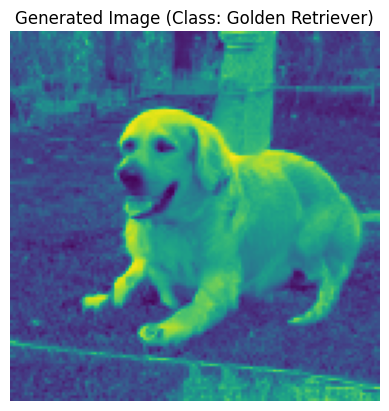

In [12]:
# Function to denormalize the image tensor for visualization
def denormalize(img_tensor):
    """Scale the tensor values from [-1, 1] to [0, 1] for visualization."""
    img_tensor = (img_tensor + 1) / 2  # Map [-1, 1] to [0, 1]
    img_tensor = img_tensor.clamp(0, 1)  # Ensure all values are within [0, 1]
    return img_tensor

# Denormalize the generated image tensor for visualization
generated_images = denormalize(generated_images.cpu())  # Move tensor to CPU and scale values

# Convert the first image in the batch to a PIL image
img = ToPILImage()(generated_images[0])

# Display the image using matplotlib
plt.imshow(img)
plt.axis("off")  # Hide axis labels for cleaner visualization
plt.title("Generated Image (Class: Golden Retriever)")  # Title to indicate the class
plt.show()


## Save Generated Image

Save the generated image to disk.

In [ ]:
img.save("generated_golden_retriever.png")
print("Image saved as 'generated_golden_retriever.png'")
